In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import logging
from typing import Union, Tuple
import random
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [50]:
# Adjust logging level if needed
logging.basicConfig(level=logging.INFO)

In [51]:
TEST_SIZE = 0.8

# Data Processing

In [52]:
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df

In [53]:
def process_data(
    df: pd.DataFrame, target: str, test_size: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    print("training data has %d observation with %d features" % X_train.shape)
    print("test data has %d observation with %d features" % X_test.shape)

    return X_train, X_test, y_train, y_test

# Active Learining Baseline

In [54]:
def active_learning_baseline(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    model_class: type,
    n_iter: int,
    sample_size: int,
) -> BaseEstimator:
    """
    Conducts active learning by iteratively selecting the most uncertain samples and retraining the model.

    Parameters:
    - X_train, y_train: Initial training set.
    - X_test, y_test: Pool of unlabeled samples.
    - model_class: The classifier class to be used.
    - n_iter: Number of active learning iterations.
    - sample_size: Number of samples to query in each iteration.

    Returns:
    - Trained model after the last iteration of active learning.
    """
    # Initialize the model with the first sample of data
    model = model_class()
    model.fit(X_train, y_train)

    # Evaluate initial model
    y_pred_initial = model.predict(X_test)
    print(f"Initial Model Accuracy: {accuracy_score(y_test, y_pred_initial)}\n")

    # Active learning loop
    accuracy_scores = []
    for i in range(n_iter):

        # Check if there are enough samples left to continue
        if len(X_test) < sample_size:
            print(f"Not enough samples left to continue after {i} iterations.")
            break
        else:
            print(
                f"Iteration {i+1}: training model with {len(X_train)} samples and testing on {len(X_test)} samples."
            )

        # Predict probabilities on the remaining test set
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate uncertainty as the samples closest to the decision threshold
        uncertainty = 1 - 2 * np.abs(y_pred_proba - 0.5)
        uncertainty_idx = np.argpartition(uncertainty, -sample_size)[-sample_size:]

        # Label the most uncertain samples
        X_uncertainty = X_test.iloc[uncertainty_idx]
        y_uncertainty = y_test.iloc[uncertainty_idx]

        # Add the newly labeled samples to the training data
        X_train = pd.concat([X_train, X_uncertainty])
        y_train = pd.concat([y_train, y_uncertainty])

        # Remove the newly labeled samples from the test data
        X_test = X_test.drop(X_test.index[uncertainty_idx])
        y_test = y_test.drop(y_test.index[uncertainty_idx])

        # Reinitialize and train the model with the new training data
        model = model_class()
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        print(f"Model Accuracy after iteration {i+1}: {accuracy}\n")
        # print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
        # print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
        # print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")

    return model, accuracy_scores

# Active Learning EMM

## Beam Search

In [55]:
class Description:

    def __init__(
        self, attribute: str = None, value: Union[str, float, int, bool, list] = None
    ):
        self.description = {}
        if attribute is not None:
            self.description[attribute] = value

    def __contains__(self, col):
        return col in self.description

    def extend(self, attribute, value):
        self.description[attribute] = value
        return self

    def decrypt(self, translation):
        for key, value in self.description.items():
            if key in translation:
                self.description[key] = translation[key][value]

    def get_mask(self, df):
        if not self.description:
            return pd.Series([True] * len(df), index=df.index)
        mask = pd.Series([True] * len(df), index=df.index)
        for attribute, value in self.description.items():
            if isinstance(value, list) and len(value) == 2:
                # Apply range condition
                mask &= (df[attribute] > value[0]) & (df[attribute] <= value[1])
            else:
                # Apply equality condition
                mask &= df[attribute] == value
        return mask

    def __str__(self):
        if not self.description:
            return "all"
        else:
            result = []
            for key, value in self.description.items():
                if isinstance(value, list) and len(value) == 2:
                    result.append(f"{value[0]:.2f} < {key} ≤ {value[1]:.2f}")
                else:
                    result.append(f"{key} = {value}")
            return " AND ".join(result)


class Subgroup:

    def __init__(self, data: pd.DataFrame, description: Description):
        self.data = data
        self.description = description
        self.score = None
        self.coverage = None

    @classmethod
    def create(cls, df: pd.DataFrame, description: Description):
        mask = description.get_mask(df)
        data = df[mask]
        return cls(data, description)

    def evaluate_quality(
        self, overall_stats: dict, quality_measure_func, min_size, target
    ):
        if self.size < min_size:
            self.score = -np.inf  # Esclude sottogruppi troppo piccoli
        else:
            self.score = quality_measure_func(self.data, overall_stats, target)

    def decrypt_description(self, translation):
        self.description.decrypt(translation)

    @property
    def size(self):
        return len(self.data)

    def print(self):
        logging.debug(f"{str(self.description)} {self.score} ({self.size})")


class Beam:

    def __init__(self, settings: dict):
        self.subgroups = []
        self.candidates = []
        self.max_items = settings["width"]
        self.candidate_size = int(
            settings.get("candidate_size", settings["width"] ** 2)
        )
        self.strategy = settings["strategy"]
        self.min_score = None
        self.scores = []

    def add(self, subgroup: Subgroup):
        if subgroup.score == -np.inf:
            return  # Skip subgroups with invalid scores

        if len(self.candidates) < self.candidate_size:
            self.candidates.append(subgroup)
            self.scores.append(subgroup.score)
            self.min_score = (
                min(self.scores) if self.strategy == "maximize" else max(self.scores)
            )
        elif (self.strategy == "maximize" and subgroup.score > self.min_score) or (
            self.strategy == "minimize" and subgroup.score < self.min_score
        ):
            idx = self.scores.index(self.min_score)
            del self.scores[idx]
            del self.candidates[idx]
            self.candidates.append(subgroup)
            self.scores.append(subgroup.score)
            self.min_score = (
                min(self.scores) if self.strategy == "maximize" else max(self.scores)
            )

    def sort(self, attribute: str = "score") -> None:
        if attribute == "score":
            self.candidates.sort(
                key=lambda x: x.score, reverse=(self.strategy == "maximize")
            )
            self.subgroups.sort(
                key=lambda x: x.score, reverse=(self.strategy == "maximize")
            )
        elif attribute == "coverage":
            self.candidates.sort(
                key=lambda x: x.score * x.coverage,
                reverse=(self.strategy == "maximize"),
            )
        else:
            raise ValueError("Invalid sort attribute")

    def select_cover_based(self):
        self.sort()
        if len(self.candidates) > self.max_items:
            index = np.array([], dtype=int)
            for subgroup in self.candidates:
                overlap_size = np.intersect1d(subgroup.data.index.values, index).size
                if subgroup.data.index.size == 0:
                    subgroup.coverage = 0
                else:
                    subgroup.coverage = 1 - (overlap_size / subgroup.data.index.size)
                index = np.unique(np.concatenate((index, subgroup.data.index.values)))
            self.sort(attribute="coverage")
        self.subgroups = self.candidates[: self.max_items]
        self.scores = [s.score for s in self.subgroups]
        self.min_score = (
            min(self.scores) if self.strategy == "maximize" else max(self.scores)
        )

    def decrypt_descriptions(self, translation):
        for s in self.subgroups:
            s.decrypt_description(translation)

    def print(self):
        self.sort(attribute="coverage")
        logging.debug("-" * 20)
        for s in self.subgroups:
            s.print()


# Quality Measures


def mean_uncertainty_deviation(
    subgroup_data: pd.DataFrame, overall_stats: dict, target: str
) -> float:
    subgroup_mean = subgroup_data[target].mean()
    return subgroup_mean - overall_stats["mean"]


def z_score_uncertainty(
    subgroup_data: pd.DataFrame, overall_stats: dict, target: str
) -> float:
    subgroup_mean = subgroup_data[target].mean()
    subgroup_std = subgroup_data[target].std()
    subgroup_stderr = subgroup_std / np.sqrt(len(subgroup_data))
    if subgroup_std == 0:
        return 0
    return (subgroup_mean - overall_stats["mean"]) / subgroup_stderr


def calculate_entropy(subgroup_size, total_size):
    n = subgroup_size
    N = total_size
    nC = N - n  # Complementary group size

    assert (
        0 <= subgroup_size <= total_size
    ), "Subgroup size must be within the range from 0 to total size."

    # Calculate proportions
    p = n / N
    pC = nC / N

    # Calculate entropy components, avoiding log(0) issues by adding a small epsilon
    epsilon = 1e-10
    entropy = -(p * np.log2(p + epsilon) + pC * np.log2(pC + epsilon))

    return entropy


def wracc_uncertainty(
    subgroup_data: pd.DataFrame, overall_stats: dict, target: str
) -> float:
    subgroup_mean = subgroup_data[target].mean()

    # Calculate entropy for the subgroup
    entropy_weight = calculate_entropy(len(subgroup_data), overall_stats["total_count"])
    assert (
        -0.0001 <= entropy_weight <= 1.0001
    ), f"Entropy weight {entropy_weight} out of bounds"

    # Return the uncertainty weighted only by the calculated entropy
    return (subgroup_mean - overall_stats["mean"]) * entropy_weight


def expand_description(
    description: Description, df: pd.DataFrame, target: str, num_bins=4
):
    new_descriptions = []
    used_attributes = set(description.description.keys())
    for attribute in df.columns:
        if attribute in used_attributes or attribute == target:
            continue
        if pd.api.types.is_numeric_dtype(df[attribute]):
            # For numerical attributes, create bins
            # bins = np.linspace(df[attribute].min(), df[attribute].max(), num_bins + 1)
            bins = np.quantile(df[attribute].dropna(), np.linspace(0, 1, num_bins + 1))
            for i in range(len(bins) - 1):
                bin_range = [bins[i], bins[i + 1]]
                new_desc = Description()
                new_desc.description = description.description.copy()
                new_desc.extend(attribute, bin_range)
                new_descriptions.append(new_desc)
        else:
            # For categorical attributes, use unique values
            unique_values = df[attribute].unique()
            for value in unique_values:
                new_desc = Description()
                new_desc.description = description.description.copy()
                new_desc.extend(attribute, value)
                new_descriptions.append(new_desc)
    return new_descriptions


def beam_search(df: pd.DataFrame, settings: dict):

    if "target" not in settings:
        raise ValueError("Target attribute not specified in settings")

    target = settings["target"]

    # If settings have attributes key, filter the dataframe
    if "attributes" in settings:
        df = df[settings["attributes"] + [target]]

    overall_mean = df[target].mean()
    overall_std = df[target].std()

    overall_stats = {
        "mean": overall_mean,
        "std": overall_std,
        "total_count": len(df),
        "num_bins": settings.get("num_bins", 4),
    }

    min_size = settings.get("min_size_percentage", 1) * df.shape[0] / 100

    # Select the quality measure function
    quality_measure_name = settings.get("quality_measure", "mean_uncertainty_deviation")
    if quality_measure_name == "mean_uncertainty_deviation":
        quality_measure_func = mean_uncertainty_deviation
    elif quality_measure_name == "z_score_uncertainty":
        quality_measure_func = z_score_uncertainty
    elif quality_measure_name == "wracc_uncertainty":
        quality_measure_func = wracc_uncertainty
    else:
        raise ValueError(f"Unknown quality measure: {quality_measure_name}")

    initial_description = Description()
    initial_subgroup = Subgroup.create(df, initial_description)
    initial_subgroup.evaluate_quality(
        overall_stats,
        quality_measure_func,
        min_size,
        target,
    )

    beam = Beam(settings)
    beam.add(initial_subgroup)

    max_depth = settings.get("max_depth", 3)
    for depth in range(max_depth):
        logging.debug(f"Depth {depth+1}")
        for subgroup in beam.subgroups:
            expanded_descriptions = expand_description(
                subgroup.description, df, target, num_bins=settings.get("num_bins", 4)
            )
            for description in expanded_descriptions:
                new_subgroup = Subgroup.create(df, description)
                new_subgroup.evaluate_quality(
                    overall_stats,
                    quality_measure_func,
                    min_size,
                    target,
                )
                beam.add(new_subgroup)
        beam.select_cover_based()

    beam.print()
    return beam.subgroups

## EMM

In [56]:
def active_learning_EMM(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    model_class: type,
    n_iter: int,
    settings: dict,
    samples_per_subgroup: int,
    sample_technique: str = "uncertainty",
) -> BaseEstimator:
    """
    Conducts active learning by iteratively selecting the most uncertain samples and retraining the model.

    Parameters:
    - X_train, y_train: Initial training set.
    - X_test, y_test: Pool of unlabeled samples.
    - model_class: The classifier class to be used.
    - n_iter: Number of active learning iterations.
    - samples_per_subgroup: Number of samples to query from each subgroup per iteration.

    Returns:
    - Trained model after the last iteration of active learning.
    """

    # Compute the number of total samples
    sample_size = settings["width"] * samples_per_subgroup

    # Initialize the model with the first sample of data
    model = model_class()
    model.fit(X_train, y_train)

    # Evaluate initial model
    y_pred_initial = model.predict(X_test)
    print(f"Initial Model Accuracy: {accuracy_score(y_test, y_pred_initial)}\n")

    # Active learning loop
    accuracy_scores = []
    for i in range(n_iter):

        # Check if there are enough samples left to continue
        if len(X_test) < sample_size:
            print(f"Not enough samples left to continue after {i} iterations.")
            break
        else:
            print(
                f"Iteration {i+1}: training model with {len(X_train)} samples and testing on {len(X_test)} samples."
            )

        # Predict probabilities on the remaining test set
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate uncertainty as the samples closest to the decision threshold
        uncertainty = 1 - 2 * np.abs(y_pred_proba - 0.5)

        # Add the uncertainty score to the dataframe
        X_test["Uncertainty"] = uncertainty

        # Run the beam search algorithm
        subgroups = beam_search(X_test, settings)

        # Sample the most uncertain samples from the subgroups
        sampled_data = pd.DataFrame()

        sampled_indices = set()  # Track indices of already sampled data
        total_samples_needed = sample_size

        for subgroup in subgroups:
            subgroup_data = subgroup.data
            if sample_technique == "uncertainty":
                subgroup_data = subgroup_data.sort_values(
                    by="Uncertainty", ascending=False
                )
            elif sample_technique == "random":
                subgroup_data = subgroup_data.sample(
                    n=min(
                        len(subgroup_data), total_samples_needed - len(sampled_indices)
                    ),
                    replace=False,
                )

            # Filter to ensure only new unique samples are added
            new_samples = subgroup_data.loc[~subgroup_data.index.isin(sampled_indices)]
            new_samples = new_samples.head(samples_per_subgroup)
            sampled_indices.update(new_samples.index)

            sampled_data = pd.concat([sampled_data, new_samples])
            # if len(sampled_indices) >= total_samples_needed:
            #     break

        # Remove the sampled data from the test set and add it to the training set
        sampled_indices = sampled_data.index

        sampled_data_X = X_test.loc[sampled_indices]

        # Remove the uncertainty column
        sampled_data_X.drop(columns="Uncertainty", inplace=True)

        sampled_data_y = y_test.loc[sampled_indices]

        X_train = pd.concat([X_train, sampled_data_X])

        y_train = pd.concat([y_train, sampled_data_y])

        X_test.drop(index=sampled_indices, inplace=True)

        y_test.drop(index=sampled_indices, inplace=True)

        # Delete the uncertainty column
        X_test.drop(columns="Uncertainty", inplace=True)

        # Reinitialize and train the model with the new training data
        model = model_class()
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        print(f"Model Accuracy after iteration {i+1}: {accuracy}\n")
        # print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
        # print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
        # print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")

    return model, accuracy_scores

# Experiments

In [57]:
df = load_data("./data/diabetes.csv")

## 1. EMM Qualitative Analysis

In [58]:
def add_uncertainty(df):
    model = KNeighborsClassifier()
    X_train, X_test, y_train, y_test = process_data(
        df, target="Outcome", test_size=TEST_SIZE
    )
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    uncertainty = 1 - 2 * np.abs(y_pred_proba - 0.5)
    new_df = X_test.copy()
    new_df["Uncertainty"] = uncertainty
    return new_df

In [59]:
def beam_search_info(subgroups, settings):
    total_size = 0
    for idx, sg in enumerate(subgroups, 1):
        print(f"Subgroup {idx}: {sg.description}")
        print(f"  Score ({settings['quality_measure']}): {sg.score}")
        print(f"  Size: {sg.size}")
        total_size += sg.size
        print()
    print(total_size)

### Mean Uncertainty Deviation

In [60]:
df_uncertainty = add_uncertainty(df)

settings = {
    "width": 10,
    "candidate_size": 100,
    "strategy": "maximize",
    "max_depth": 3,
    "num_bins": 4,  # Number of bins for numerical attributes
    "quality_measure": "mean_uncertainty_deviation",
    "min_size_percentage": 5,  # Percentage of the total data size
    "target": "Uncertainty",  # Target attribute for quality measure
    "attributes": [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
    ],
}

subgroups = beam_search(df_uncertainty, settings)

beam_search_info(subgroups, settings)

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Subgroup 1: 130.00 < Insulin ≤ 744.00 AND 115.00 < Glucose ≤ 140.00
  Score (mean_uncertainty_deviation): 0.2678612908578065
  Size: 49

Subgroup 2: 140.00 < Glucose ≤ 197.00 AND 3.00 < Pregnancies ≤ 6.00
  Score (mean_uncertainty_deviation): 0.23344319929685786
  Size: 37

Subgroup 3: 130.00 < Insulin ≤ 744.00 AND 0.00 < Pregnancies ≤ 1.00
  Score (mean_uncertainty_deviation): 0.25785470757933404
  Size: 31

Subgroup 4: 130.00 < Insulin ≤ 744.00 AND 24.00 < Age ≤ 29.00
  Score (mean_uncertainty_deviation): 0.25633668101386897
  Size: 34

Subgroup 5: 0.08 < DiabetesPedigreeFunction ≤ 0.24 AND 41.00 < Age ≤ 72.00
  Score (mean_uncertainty_deviation): 0.20731707317073156
  Size: 36

Subgroup 6: 130.00 < Insulin ≤ 744.00 AND 62.00 < BloodPressure ≤ 72.00
  Score (mean_uncertainty_deviation): 0.2539837398373984
  Size: 40

Subgroup 7: 140.00 < Glucose ≤ 197.00 AND 41.00 < Age ≤ 72.00
  Score (me

### Z-Score

In [61]:
df_uncertainty = add_uncertainty(df)

settings = {
    "width": 10,
    "candidate_size": 100,
    "strategy": "maximize",
    "max_depth": 3,
    "num_bins": 4,  # Number of bins for numerical attributes
    "quality_measure": "z_score_uncertainty",
    "min_size_percentage": 5,  # Percentage of the total data size
    "target": "Uncertainty",  # Target attribute for quality measure
    "attributes": [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
    ],
}

subgroups = beam_search(df_uncertainty, settings)

beam_search_info(subgroups, settings)

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Subgroup 1: 130.00 < Insulin ≤ 744.00 AND 115.00 < Glucose ≤ 140.00
  Score (z_score_uncertainty): 9.555610725060227
  Size: 49

Subgroup 2: 130.00 < Insulin ≤ 744.00
  Score (z_score_uncertainty): 8.739287908163641
  Size: 147

Subgroup 3: 36.50 < BMI ≤ 67.10 AND 140.00 < Glucose ≤ 197.00
  Score (z_score_uncertainty): 6.549331808657224
  Size: 52

Subgroup 4: 0.08 < DiabetesPedigreeFunction ≤ 0.24 AND 41.00 < Age ≤ 72.00
  Score (z_score_uncertainty): 5.611204774842944
  Size: 36

Subgroup 5: 140.00 < Glucose ≤ 197.00
  Score (z_score_uncertainty): 6.504169556911853
  Size: 153

Subgroup 6: 41.00 < Age ≤ 72.00
  Score (z_score_uncertainty): 4.804209376803343
  Size: 136

Subgroup 7: 115.00 < Glucose ≤ 140.00 AND 32.10 < BMI ≤ 36.50
  Score (z_score_uncertainty): 3.170175012833412
  Size: 49

Subgroup 8: 80.00 < BloodPressure ≤ 114.00
  Score (z_score_uncertainty): 3.573765606470595
  Size:

### Wracc Uncertainty

In [62]:
df_uncertainty = add_uncertainty(df)

settings = {
    "width": 10,
    "candidate_size": 100,
    "strategy": "maximize",
    "max_depth": 3,
    "num_bins": 4,  # Number of bins for numerical attributes
    "quality_measure": "wracc_uncertainty",
    "min_size_percentage": 5,  # Percentage of the total data size
    "target": "Uncertainty",  # Target attribute for quality measure
    "attributes": [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
    ],
}

subgroups = beam_search(df_uncertainty, settings)

beam_search_info(subgroups, settings)

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Subgroup 1: 130.00 < Insulin ≤ 744.00
  Score (wracc_uncertainty): 0.15423327811373136
  Size: 147

Subgroup 2: 140.00 < Glucose ≤ 197.00
  Score (wracc_uncertainty): 0.12494251340583654
  Size: 153

Subgroup 3: 41.00 < Age ≤ 72.00
  Score (wracc_uncertainty): 0.09002164885770851
  Size: 136

Subgroup 4: 80.00 < BloodPressure ≤ 114.00
  Score (wracc_uncertainty): 0.07062734355659088
  Size: 134

Subgroup 5: 36.50 < BMI ≤ 67.10
  Score (wracc_uncertainty): 0.0699285855699746
  Size: 153

Subgroup 6: 115.00 < Glucose ≤ 140.00
  Score (wracc_uncertainty): 0.05268790280266298
  Size: 154

Subgroup 7: 3.00 < Pregnancies ≤ 6.00
  Score (wracc_uncertainty): 0.0496677451178893
  Size: 136

Subgroup 8: 6.00 < Pregnancies ≤ 15.00
  Score (wracc_uncertainty): 0.04323825244347502
  Size: 135

Subgroup 9: 0.08 < DiabetesPedigreeFunction ≤ 0.24 AND 32.10 < BMI ≤ 36.50
  Score (wracc_uncertainty): 0.031890

## 2. Active Learning

In [63]:
def plot_accuracy(accuracy_lists: list[list[float]], labels: list[str]):
    import matplotlib.pyplot as plt

    # Asserting that the number of accuracy lists and labels are the same
    assert len(accuracy_lists) == len(
        labels
    ), "Number of lists and labels should be the same"

    # Increasing the figure size
    plt.figure(figsize=(10, 8))

    for i, accuracy in enumerate(accuracy_lists):
        plt.plot(accuracy, label=labels[i])

    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Iterations")

    # Modifying legend properties
    plt.legend(
        loc="upper left", fontsize="small", fancybox=True, framealpha=0.5, ncol=1
    )

    plt.show()

In [64]:
def evaluate_active_learning(
    df, quality_measures, sample_techniques, sample_per_subgroup
):

    accuracy_lists = []
    labels = []

    for quality_measure in quality_measures:
        for sample_technique in sample_techniques:

            X_train, X_test, y_train, y_test = process_data(
                df, target="Outcome", test_size=TEST_SIZE
            )

            print(
                f"Quality Measure: {quality_measure}, Sample Technique: {sample_technique}"
            )
            settings = {
                "width": 10,
                "candidate_size": 100,
                "strategy": "maximize",
                "max_depth": 3,
                "num_bins": 4,  # Number of bins for numerical attributes
                "quality_measure": quality_measure,
                "min_size_percentage": 5,  # Minimum size of subgroups (percentage of total data)
                "target": "Uncertainty",  # Target attribute for quality measure
                "attributes": [
                    "Pregnancies",
                    "Glucose",
                    "BloodPressure",
                    "SkinThickness",
                    "Insulin",
                    "BMI",
                    "DiabetesPedigreeFunction",
                    "Age",
                ],
            }

            model, accuracy = active_learning_EMM(
                X_train,
                X_test,
                y_train,
                y_test,
                KNeighborsClassifier,
                n_iter=10,
                settings=settings,
                samples_per_subgroup=sample_per_subgroup,
                sample_technique=sample_technique,
            )
            labels.append(f"{quality_measure} - {sample_technique}")
            accuracy_lists.append(accuracy)
    return accuracy_lists, labels

### 1 Sample per subgroup

In [65]:
# Iterate over different quality measures
quality_measures = [
    "mean_uncertainty_deviation",
    "z_score_uncertainty",
    "wracc_uncertainty",
]
sample_techniques = ["uncertainty", "random"]

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Quality Measure: mean_uncertainty_deviation, Sample Technique: uncertainty
Initial Model Accuracy: 0.6829268292682927

Iteration 1: training model with 153 samples and testing on 615 samples.
Model Accuracy after iteration 1: 0.6809917355371901

Iteration 2: training model with 163 samples and testing on 605 samples.
Model Accuracy after iteration 2: 0.6857142857142857

Iteration 3: training model with 173 samples and testing on 595 samples.
Model Accuracy after iteration 3: 0.6820512820512821

Iteration 4: training model with 183 samples and testing on 585 samples.
Model Accuracy after iteration 4: 0.6991304347826087

Iteration 5: training model with 193 samples and testing on 575 samples.
Model Accuracy after iteration 5: 0.7044247787610619

Iteration 6: training model with 203 samples and testing on 565 samples.
Model Accuracy after iteration 6: 0.6972972972972973

Iteration 7: training m

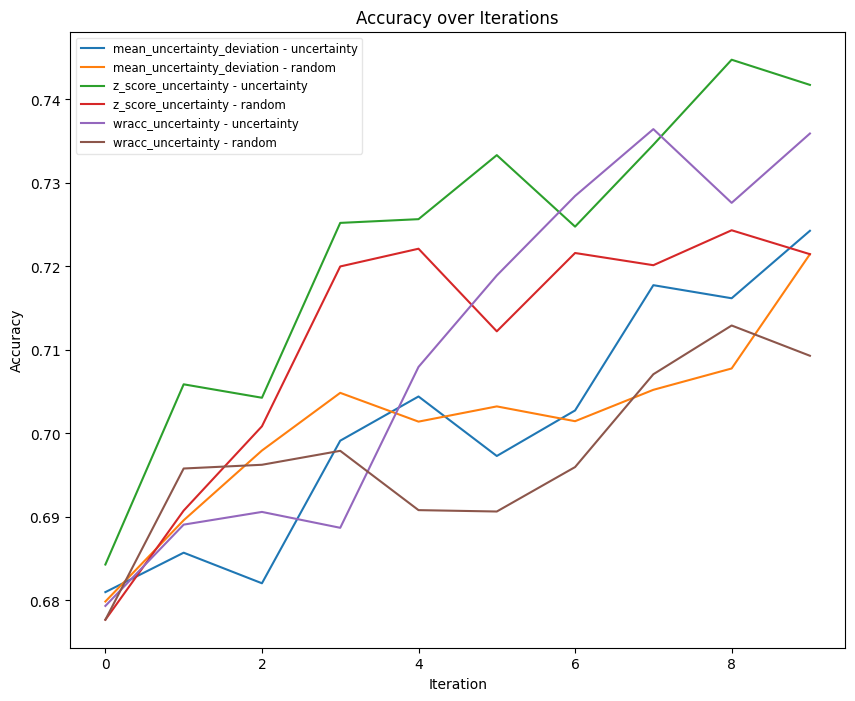

In [66]:
accuracy_lists, labels = evaluate_active_learning(
    df, quality_measures, sample_techniques, sample_per_subgroup=1
)

plot_accuracy(accuracy_lists, labels)

### 2 Sample per subgroup

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Quality Measure: mean_uncertainty_deviation, Sample Technique: uncertainty
Initial Model Accuracy: 0.6829268292682927

Iteration 1: training model with 153 samples and testing on 615 samples.
Model Accuracy after iteration 1: 0.6756302521008404

Iteration 2: training model with 173 samples and testing on 595 samples.
Model Accuracy after iteration 2: 0.697391304347826

Iteration 3: training model with 193 samples and testing on 575 samples.
Model Accuracy after iteration 3: 0.7081081081081081

Iteration 4: training model with 213 samples and testing on 555 samples.
Model Accuracy after iteration 4: 0.7140186915887851

Iteration 5: training model with 233 samples and testing on 535 samples.
Model Accuracy after iteration 5: 0.7223300970873786

Iteration 6: training model with 253 samples and testing on 515 samples.
Model Accuracy after iteration 6: 0.7353535353535353

Iteration 7: training mo

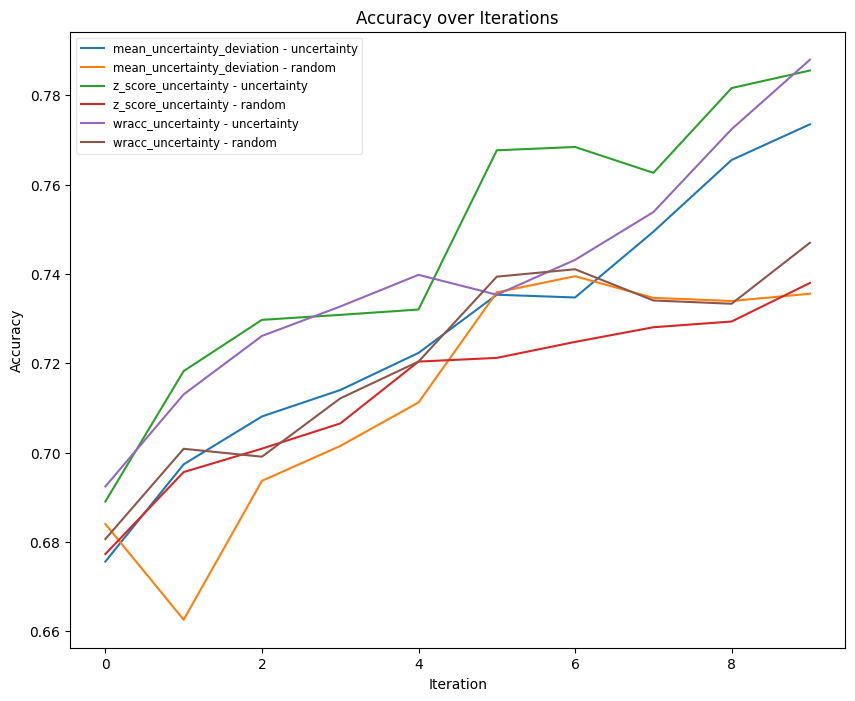

In [67]:
accuracy_lists, labels = evaluate_active_learning(
    df, quality_measures, sample_techniques, sample_per_subgroup=2
)

plot_accuracy(accuracy_lists, labels)

### 5 Samples per subgroup

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Quality Measure: mean_uncertainty_deviation, Sample Technique: uncertainty
Initial Model Accuracy: 0.6829268292682927

Iteration 1: training model with 153 samples and testing on 615 samples.
Model Accuracy after iteration 1: 0.7185840707964601

Iteration 2: training model with 203 samples and testing on 565 samples.
Model Accuracy after iteration 2: 0.7398058252427184

Iteration 3: training model with 253 samples and testing on 515 samples.
Model Accuracy after iteration 3: 0.7548387096774194

Iteration 4: training model with 303 samples and testing on 465 samples.
Model Accuracy after iteration 4: 0.7710843373493976

Iteration 5: training model with 353 samples and testing on 415 samples.
Model Accuracy after iteration 5: 0.8

Iteration 6: training model with 403 samples and testing on 365 samples.
Model Accuracy after iteration 6: 0.8317460317460318

Iteration 7: training model with 453 s

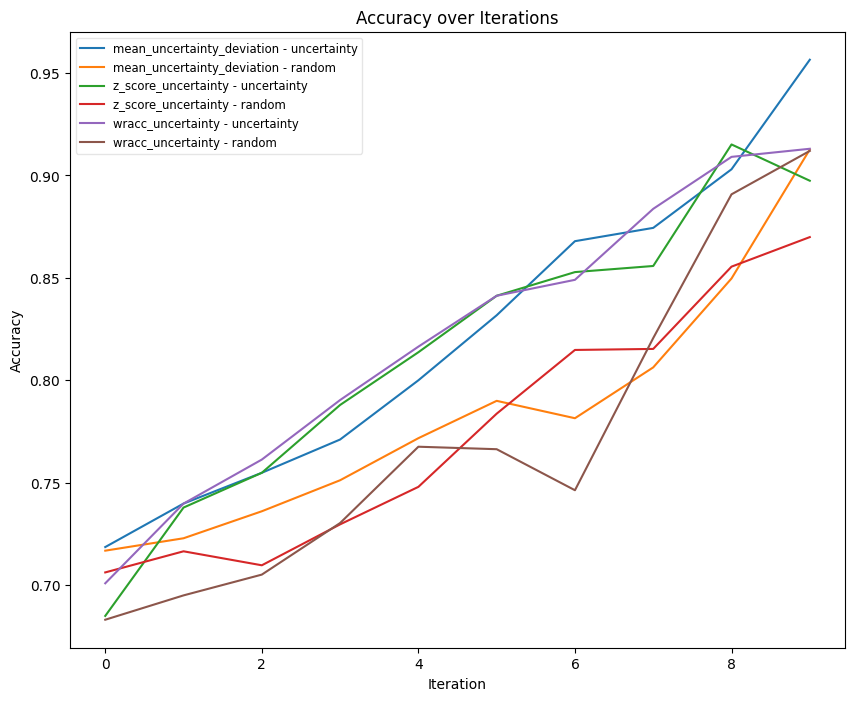

In [68]:
accuracy_lists, labels = evaluate_active_learning(
    df, quality_measures, sample_techniques, sample_per_subgroup=5
)

plot_accuracy(accuracy_lists, labels)

## 3. Baseline Comparison

In [69]:
def compare_with_baseline(df, quality_measure, sample_technique, sample_per_subgroup):

    accuracy_lists = []
    labels = []

    settings = {
        "width": 10,
        "candidate_size": 100,
        "strategy": "maximize",
        "max_depth": 3,
        "num_bins": 4,  # Number of bins for numerical attributes
        "quality_measure": quality_measure,
        "min_size_percentage": 5,  # Minimum size of subgroups
        "target": "Uncertainty",  # Target attribute for quality measure
        "attributes": [
            "Pregnancies",
            "Glucose",
            "BloodPressure",
            "SkinThickness",
            "Insulin",
            "BMI",
            "DiabetesPedigreeFunction",
            "Age",
        ],
    }
    sample_size = settings["width"] * sample_per_subgroup

    X_train, X_test, y_train, y_test = process_data(
        df, target="Outcome", test_size=TEST_SIZE
    )
    model, accuracy_baseline = active_learning_baseline(
        X_train,
        X_test,
        y_train,
        y_test,
        KNeighborsClassifier,
        n_iter=10,
        sample_size=sample_size,
    )
    accuracy_lists.append(accuracy_baseline)
    labels.append("Baseline")

    X_train, X_test, y_train, y_test = process_data(
        df, target="Outcome", test_size=TEST_SIZE
    )
    model, accuracy_EMM = active_learning_EMM(
        X_train,
        X_test,
        y_train,
        y_test,
        KNeighborsClassifier,
        n_iter=10,
        settings=settings,
        samples_per_subgroup=sample_per_subgroup,
        sample_technique=sample_technique,
    )
    accuracy_lists.append(accuracy_EMM)
    labels.append("EMM")

    return accuracy_lists, labels

### 1 sample per subgroup

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Initial Model Accuracy: 0.6829268292682927

Iteration 1: training model with 153 samples and testing on 615 samples.
Model Accuracy after iteration 1: 0.6925619834710743

Iteration 2: training model with 163 samples and testing on 605 samples.
Model Accuracy after iteration 2: 0.6941176470588235

Iteration 3: training model with 173 samples and testing on 595 samples.
Model Accuracy after iteration 3: 0.7042735042735043

Iteration 4: training model with 183 samples and testing on 585 samples.
Model Accuracy after iteration 4: 0.7095652173913043

Iteration 5: training model with 193 samples and testing on 575 samples.
Model Accuracy after iteration 5: 0.7097345132743362

Iteration 6: training model with 203 samples and testing on 565 samples.
Model Accuracy after iteration 6: 0.736936936936937

Iteration 7: training model with 213 samples and testing on 555 samples.
Model Accuracy after itera

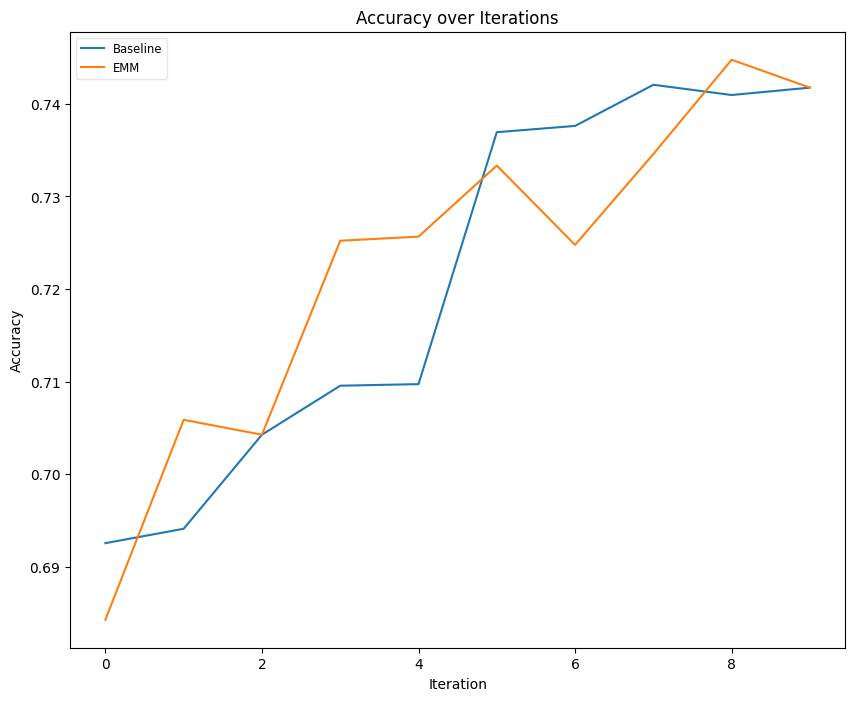

In [70]:
accuracy, labels = compare_with_baseline(
    df, "z_score_uncertainty", "uncertainty", sample_per_subgroup=1
)
plot_accuracy(accuracy, labels)

### 2 samples per subgroup

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Initial Model Accuracy: 0.6829268292682927

Iteration 1: training model with 153 samples and testing on 615 samples.
Model Accuracy after iteration 1: 0.6974789915966386

Iteration 2: training model with 173 samples and testing on 595 samples.
Model Accuracy after iteration 2: 0.6956521739130435

Iteration 3: training model with 193 samples and testing on 575 samples.
Model Accuracy after iteration 3: 0.7171171171171171

Iteration 4: training model with 213 samples and testing on 555 samples.
Model Accuracy after iteration 4: 0.7345794392523365

Iteration 5: training model with 233 samples and testing on 535 samples.
Model Accuracy after iteration 5: 0.7262135922330097

Iteration 6: training model with 253 samples and testing on 515 samples.
Model Accuracy after iteration 6: 0.7373737373737373

Iteration 7: training model with 273 samples and testing on 495 samples.
Model Accuracy after iter

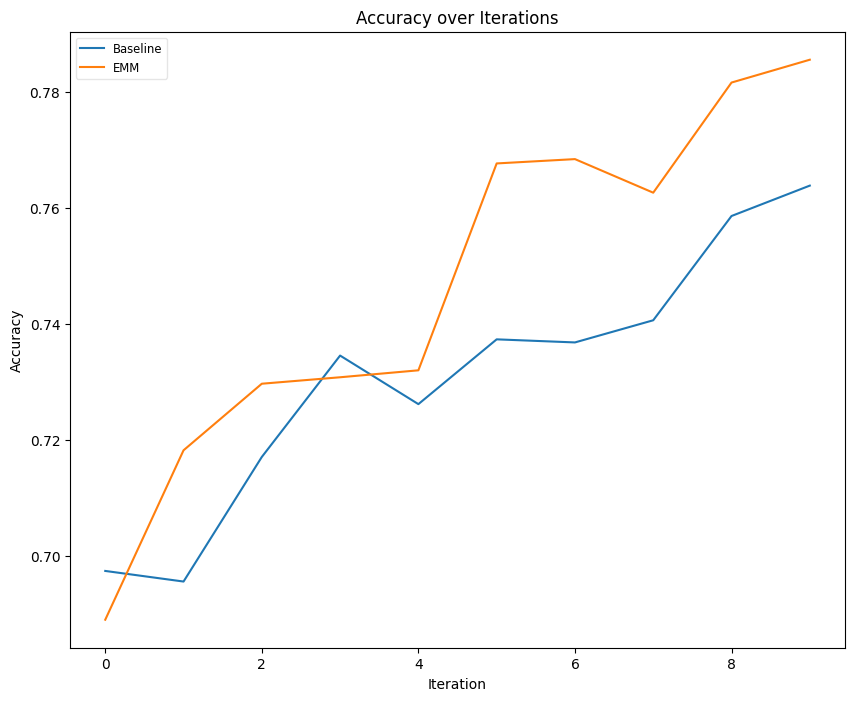

In [71]:
accuracy, labels = compare_with_baseline(
    df, "z_score_uncertainty", "uncertainty", sample_per_subgroup=2
)
plot_accuracy(accuracy, labels)

### 5 Samples per subgroup

training data has 153 observation with 8 features
test data has 615 observation with 8 features
Initial Model Accuracy: 0.6829268292682927

Iteration 1: training model with 153 samples and testing on 615 samples.
Model Accuracy after iteration 1: 0.7115044247787611

Iteration 2: training model with 203 samples and testing on 565 samples.
Model Accuracy after iteration 2: 0.7300970873786408

Iteration 3: training model with 253 samples and testing on 515 samples.
Model Accuracy after iteration 3: 0.7462365591397849

Iteration 4: training model with 303 samples and testing on 465 samples.
Model Accuracy after iteration 4: 0.7783132530120482

Iteration 5: training model with 353 samples and testing on 415 samples.
Model Accuracy after iteration 5: 0.8082191780821918

Iteration 6: training model with 403 samples and testing on 365 samples.
Model Accuracy after iteration 6: 0.8253968253968254

Iteration 7: training model with 453 samples and testing on 315 samples.
Model Accuracy after iter

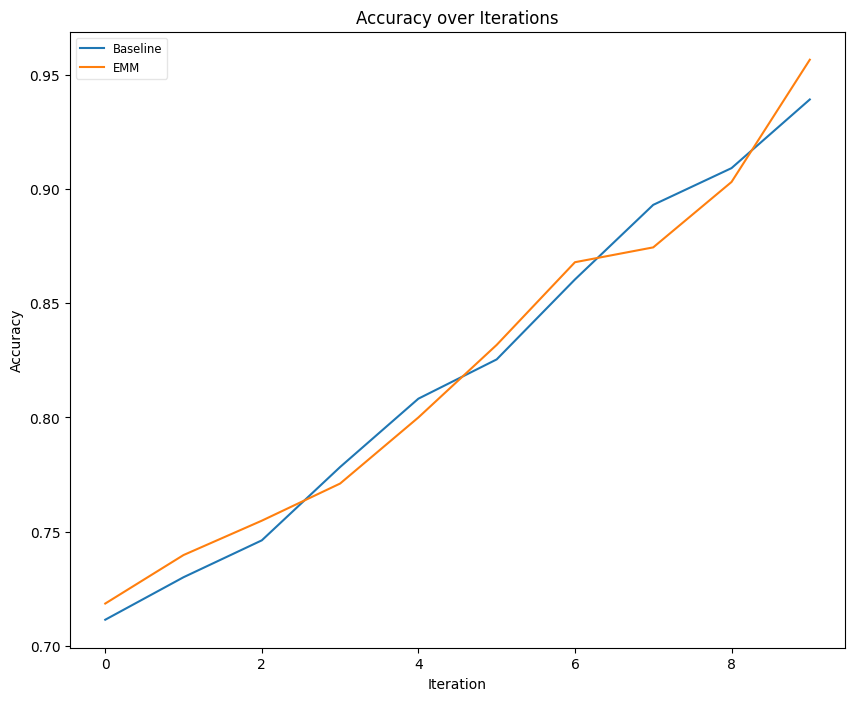

In [72]:
accuracy, labels = compare_with_baseline(
    df, "mean_uncertainty_deviation", "uncertainty", sample_per_subgroup=5
)
plot_accuracy(accuracy, labels)